<a href="https://colab.research.google.com/github/AinaHerrera/ejerciciosIA/blob/main/Checkpoint_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SenseAI x Student Stress Monitoring: Análisis exploratorio y variables clave**
[Kaggle dataset](https://www.kaggle.com/datasets/mdsultanulislamovi/student-stress-monitoring-datasets)

En este cuaderno, el propósito es producir hallazgos visuales y accionables que conecten directamente con el proyecto SenseAI, priorizando decisiones de producto como ajuste de carga de estudio, pausas inteligentes y tutoría adaptativa.

Contexto del problema y preguntas guía

Como parte del desarrollo de SenseAI, necesito comprender qué factores están más asociados con el estrés estudiantil para anticipar sobrecarga y ajustar la experiencia de aprendizaje. Mis preguntas guía son:

¿Qué variable representaré como nivel de estrés (target) y por qué?

¿Qué 2–5 señales (features) explican diferencias en ese target?

¿Qué patrones visuales sostienen decisiones concretas del producto (umbrales, recomendaciones, nudges)?

Descripción del dataset y alcance

Utilizo un dataset público de estrés en estudiantes que reúne variables psicosociales, académicas y somáticas (ej., calidad de sueño, presión académica, estrés financiero, apoyo social, cefalea). El alcance de este cuaderno es exploratorio: inspecciono estructura, defino target y features, genero al menos tres visualizaciones interpretadas y dejo listos los insumos para modelado ligero en una fase posterior.

In [2]:
# Sistema / utilidades
import os, re, sys, warnings
from pathlib import Path

# Ciencia de datos
import numpy as np
import pandas as pd

# Visualización (solo matplotlib)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Config general
warnings.filterwarnings("ignore")

# Opciones de pandas
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Estilo de gráficos
mpl.rcParams["figure.figsize"] = (8, 5)
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["axes.grid"] = True

# Carpetas de salida
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

# Utilidades ligeras
def snake(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "_", s.strip().lower()).strip("_")

def savefig(fname: str):
    p = FIG_DIR / fname
    plt.savefig(p, dpi=200, bbox_inches="tight")
    print(f"[Figura guardada] {p.resolve()}")

def mem_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024**2)

# Log de entorno
print("== ENTORNO LISTO ==")
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy:  {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"Figuras: {FIG_DIR.resolve()}")
print(f"Salidas: {OUT_DIR.resolve()}")



== ENTORNO LISTO ==
Python: 3.12.12
NumPy:  2.0.2
Pandas: 2.2.2
Matplotlib: 3.10.0
Figuras: /content/figures
Salidas: /content/outputs


Supuestos y criterios de inclusión de variables

Trabajo con las columnas disponibles en el CSV descargado; si hay nombres alternos o escalas distintas, estandarizo. Evito fuga de etiqueta (no uso como feature una variable que sea el mismo constructo que el target con otro nombre) y priorizo señales que SenseAI pueda intervenir (sueño, presión académica, hábitos de estudio, apoyo social).

In [3]:
CSV_PATH = "/content/StressLevelDataset.csv"
def snake(s):
    return re.sub(r'[^a-z0-9]+','_', s.strip().lower()).strip('_')

df = pd.read_csv(CSV_PATH)
df.columns = [snake(c) for c in df.columns]

print("== CARGA EXITOSA ==")
print(f"Archivo: {CSV_PATH} | Shape: {df.shape}")
print("Primeras columnas:", list(df.columns)[:12])
display(df.head())
print("\nTipos (conteo):")
print(df.dtypes.value_counts())
print("\nNulos TOP 10:")
print(df.isna().sum().sort_values(ascending=False).head(10))


== CARGA EXITOSA ==
Archivo: /content/StressLevelDataset.csv | Shape: (1100, 21)
Primeras columnas: ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs']


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,3,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,2,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,3,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,2,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,4,3,4,3,1,2,1,5,0,5,1



Tipos (conteo):
int64    21
Name: count, dtype: int64

Nulos TOP 10:
anxiety_level            0
self_esteem              0
mental_health_history    0
depression               0
headache                 0
blood_pressure           0
sleep_quality            0
breathing_problem        0
noise_level              0
living_conditions        0
dtype: int64


Definición del target (etiqueta) y justificación

Mi objetivo principal es representar el nivel de estrés del estudiante. Si existe una columna explícita (p. ej., stress_level, stress, anxiety_level o depression), la usaré como target y justificaré su elección por relevancia directa con el bienestar académico que SenseAI monitorea.
Si el dataset no incluye una etiqueta de estrés clara, construiré un índice continuo overall_stress_idx promediando (estandarizados) indicadores conceptualmente relacionados (p. ej., ansiedad, presión académica, estrés financiero) e invirtiendo la calidad de sueño si mayor=mejor. Este índice me permitirá definir umbrales prácticos para decisiones del producto.

In [4]:
import re

# (si ejecutaste C1, df ya existe)
assert "df" in globals(), "Primero ejecuta la C1 para cargar el DataFrame 'df'."

def available(cols):
    return [c for c in cols if c in df.columns]

# 1) Elegir TARGET
# Prioridad: stress_level -> stress -> anxiety_level -> depression -> derivado
candidates = ["stress_level", "stress", "anxiety_level", "depression"]
target_col = next((c for c in candidates if c in df.columns), None)

if target_col is None:
    # Derivamos un índice simple de estrés si no hay etiqueta clara
    proxies = available([
        "anxiety_level", "depression",
        "peer_pressure", "study_load",
        "sleep_quality",  # se invertirá (mayor=mejor) si procede más adelante
        "future_career_concerns", "noise_level", "basic_needs"
    ])
    if len(proxies) < 2:
        raise ValueError("No hay target explícito ni suficientes proxies para derivarlo.")
    z = df[proxies].apply(pd.to_numeric, errors="coerce")
    # invertir sleep_quality si existe (suponiendo escala mayor=mejor)
    if "sleep_quality" in z.columns:
        z["sleep_quality"] = -1 * (z["sleep_quality"] - z["sleep_quality"].mean())/z["sleep_quality"].std(ddof=0)
    z = (z - z.mean())/z.std(ddof=0)
    df["overall_stress_idx"] = z.mean(axis=1)
    target_col = "overall_stress_idx"
    target_mode = "derivado"
else:
    target_mode = "explícito"

print("== TARGET SELECCIONADO ==")
print(f"Columna: {target_col} | Modo: {target_mode}")
print("Tipo:", df[target_col].dtype)
print("Valores únicos (hasta 15):", sorted(df[target_col].unique())[:15])
print("Rango:", (np.nanmin(df[target_col]), np.nanmax(df[target_col])))

# 2) Preselección de FEATURES (máx. 5)
ranked = [
    "sleep_quality", "study_load", "social_support", "peer_pressure",
    "academic_performance", "basic_needs", "noise_level",
    "teacher_student_relationship", "future_career_concerns",
    "living_conditions", "headache", "blood_pressure", "breathing_problem"
]
features = [c for c in ranked if c in df.columns and c != target_col][:5]

# Evitar columnas índice/administrativas
features = [c for c in features if not re.fullmatch(r"(index|id)", c)]

print("\n== FEATURES PRE-SELECCIONADAS (máx 5) ==")
print(features)

# 3) Mini-resumen para el informe (SenseAI)
print("\n== BORRADOR DE JUSTIFICACIÓN ==")
if target_col in ["anxiety_level", "stress_level", "stress"]:
    print(f"- Target '{target_col}': proxy directo del nivel de estrés/ansiedad que SenseAI debe monitorear.")
elif target_col == "depression":
    print("- Target 'depression': estado afectivo relacionado con estrés académico; útil para alertas tempranas.")
else:
    print("- Target 'overall_stress_idx': índice continuo derivado que integra señales psicosociales y académicas.")

for f in features:
    msg = {
        "sleep_quality": "higiene del sueño -> ajustes de carga y pausas",
        "study_load": "dosis de estudio -> bloques más cortos o re-escalado",
        "social_support": "factor protector -> refuerzos/ritmo",
        "peer_pressure": "estresor social -> microtutoría",
        "academic_performance": "exigencia/resultados -> apoyo puntual",
        "basic_needs": "necesidades básicas -> tareas breves, objetivos alcanzables",
        "noise_level": "ambiente -> recomendaciones de enfoque",
        "teacher_student_relationship": "vínculo docente -> soporte contextual",
        "future_career_concerns": "incertidumbre -> reducción de carga",
        "living_conditions": "contexto -> flexibilidad",
        "headache": "somático -> pausas y respiración",
        "blood_pressure": "somático -> pausas y respiración",
        "breathing_problem": "somático -> pausas y respiración",
    }.get(f, "señal relevante para ajustes en SenseAI")
    print(f"- {f}: {msg}")


== TARGET SELECCIONADO ==
Columna: stress_level | Modo: explícito
Tipo: int64
Valores únicos (hasta 15): [np.int64(0), np.int64(1), np.int64(2)]
Rango: (np.int64(0), np.int64(2))

== FEATURES PRE-SELECCIONADAS (máx 5) ==
['sleep_quality', 'study_load', 'social_support', 'peer_pressure', 'academic_performance']

== BORRADOR DE JUSTIFICACIÓN ==
- Target 'stress_level': proxy directo del nivel de estrés/ansiedad que SenseAI debe monitorear.
- sleep_quality: higiene del sueño -> ajustes de carga y pausas
- study_load: dosis de estudio -> bloques más cortos o re-escalado
- social_support: factor protector -> refuerzos/ritmo
- peer_pressure: estresor social -> microtutoría
- academic_performance: exigencia/resultados -> apoyo puntual


Selección preliminar de features (2–5) y conexión con SenseAI

Para explicar variaciones del target, parto de una lista corta dependiente de la disponibilidad real del CSV:

sleep_quality: higiene del sueño; informa reducción de carga y pausas guiadas.

academic_pressure o study_hours: dosis de estudio; orienta bloques más cortos y tutoría puntual.

financial_stress: estresor externo; favorece microactividades y objetivos alcanzables.

social_support o self_esteem: factor protector; ajusta progresión y refuerzos positivos.

Señales somáticas (headache, blood_pressure): disparan nudges de respiración/descanso.
Mantendré solo 2–5 features que aporten información no redundante y con variabilidad suficiente.

In [9]:
assert "df" in globals(), "Primero ejecuta C1 y C2."

target_col = "stress_level"
features = ['sleep_quality','study_load','social_support','peer_pressure','academic_performance']
features = [c for c in features if c in df.columns and c != target_col]

# Coerción ligera a numérico
dplot = df[[target_col] + features].apply(pd.to_numeric, errors="coerce")
print("Target:", target_col)
print("Features:", features)
print("Shape EDA:", dplot.shape)




Target: stress_level
Features: ['sleep_quality', 'study_load', 'social_support', 'peer_pressure', 'academic_performance']
Shape EDA: (1100, 6)


Plan de EDA y visualizaciones de variables con respecto al target

Mi análisis exploratorio incluirá, como mínimo:

Distribución del target (histograma o barras) para entender su forma y posibles desbalances.

Relación target–feature (box/violin o barras) para observar diferencias entre grupos o rangos.

Relación entre dos features con color por target para detectar interacciones útiles.

Matriz de correlación (opcional) para evaluar redundancia entre señales numéricas.
De cada gráfico dejaré una interpretación breve (2–3 líneas) conectada a decisiones de SenseAI.

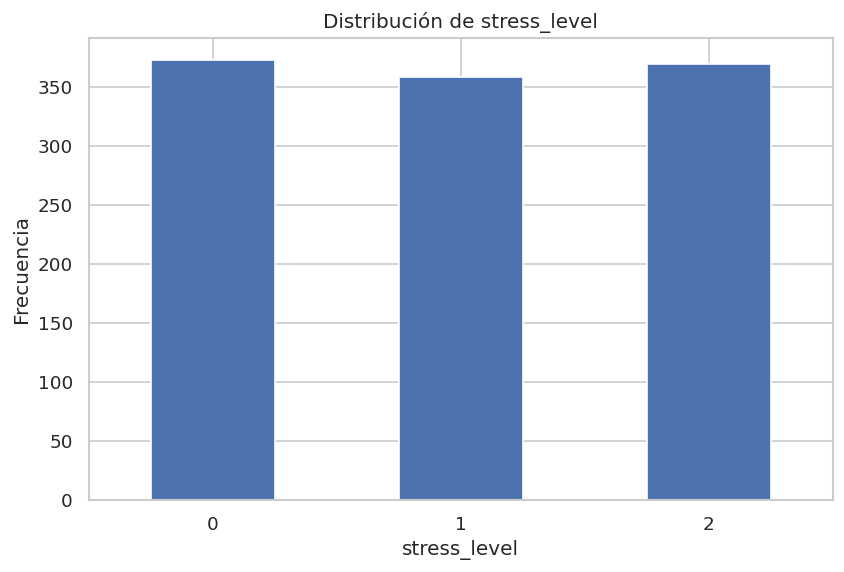

Tabla de distribución del target:


,freq,pct
stress_level,,
0,373,0.3390
1,358,0.3250
2,369,0.3350


In [10]:
assert target_col in dplot.columns, "No encuentro el target en dplot."

plt.figure()
(dplot[target_col].value_counts()
      .sort_index()
      .plot(kind="bar"))
plt.title(f"Distribución de {target_col}")
plt.xlabel(target_col); plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.show()

print("Tabla de distribución del target:")
display(dplot[target_col].value_counts()
        .sort_index()
        .to_frame("freq")
        .assign(pct=lambda x: (x["freq"]/x["freq"].sum()).round(3)))


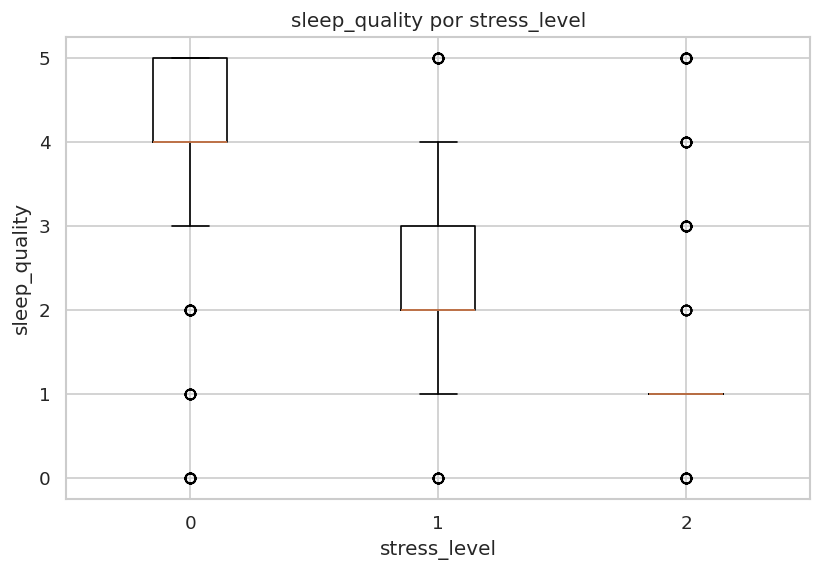

Medias por nivel de stress_level (sleep_quality):


,sleep_quality
stress_level,
0,4.1260
1,2.5310
2,1.3040


In [12]:
assert "sleep_quality" in dplot.columns, "No existe sleep_quality en dplot."

niveles = sorted(dplot[target_col].dropna().unique())
grupos = [dplot.loc[dplot[target_col]==k, "sleep_quality"].dropna() for k in niveles]
labels = [str(int(k)) for k in niveles]

plt.figure()
plt.boxplot(grupos, labels=labels, showfliers=True)
plt.title("sleep_quality por stress_level")
plt.xlabel("stress_level"); plt.ylabel("sleep_quality")
plt.show()

print("Medias por nivel de stress_level (sleep_quality):")
display(dplot.groupby(target_col)["sleep_quality"].mean().round(3))


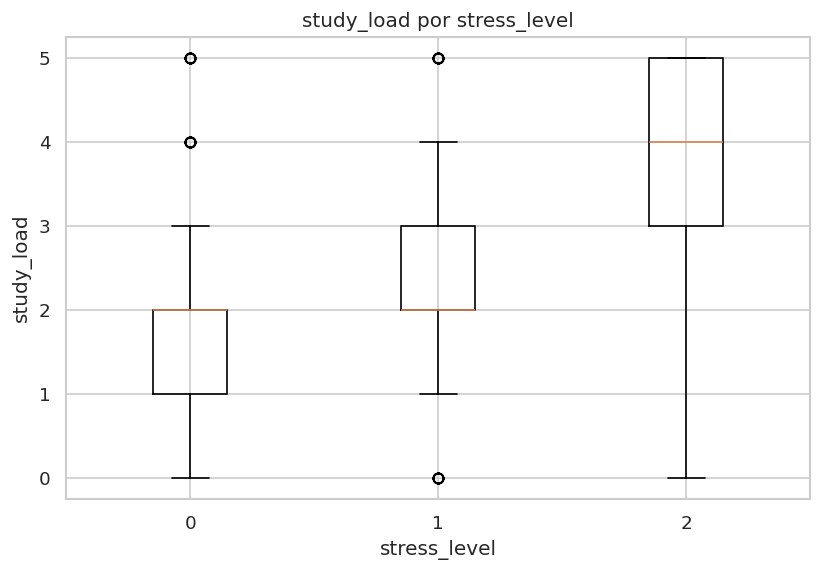

Medias por nivel de stress_level (study_load):


,study_load
stress_level,
0,1.6540
1,2.5340
2,3.6860


In [13]:
assert "study_load" in dplot.columns, "No existe study_load en dplot."

niveles = sorted(dplot[target_col].dropna().unique())
grupos = [dplot.loc[dplot[target_col]==k, "study_load"].dropna() for k in niveles]
labels = [str(int(k)) for k in niveles]

plt.figure()
plt.boxplot(grupos, labels=labels, showfliers=True)
plt.title("study_load por stress_level")
plt.xlabel("stress_level"); plt.ylabel("study_load")
plt.show()

print("Medias por nivel de stress_level (study_load):")
display(dplot.groupby(target_col)["study_load"].mean().round(3))


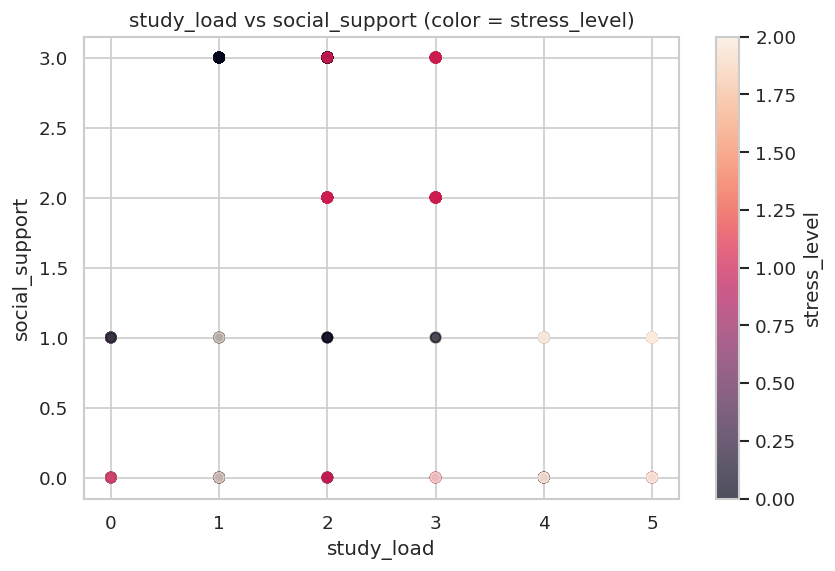

Par visualizado: study_load vs social_support


In [14]:
# Scatterplot
import matplotlib.pyplot as plt

if set(["study_load","social_support"]).issubset(dplot.columns):
    xcol, ycol = "study_load", "social_support"
elif set(["study_load","sleep_quality"]).issubset(dplot.columns):
    xcol, ycol = "study_load", "sleep_quality"
else:
    xcol, ycol = features[:2]  # último recurso

plt.figure()
sc = plt.scatter(dplot[xcol], dplot[ycol], c=dplot[target_col], alpha=0.7)
plt.title(f"{xcol} vs {ycol} (color = {target_col})")
plt.xlabel(xcol); plt.ylabel(ycol)
cbar = plt.colorbar(sc); cbar.set_label(target_col)
plt.show()

print(f"Par visualizado: {xcol} vs {ycol}")


Matriz de correlación (numérica):


,stress_level,sleep_quality,study_load,social_support,peer_pressure,academic_performance
stress_level,1.0000,-0.7490,0.6340,-0.6320,0.6910,-0.7210
sleep_quality,-0.7490,1.0000,-0.5520,0.5550,-0.6490,0.6710
study_load,0.6340,-0.5520,1.0000,-0.4730,0.5440,-0.5200
social_support,-0.6320,0.5550,-0.4730,1.0000,-0.4900,0.5680
peer_pressure,0.6910,-0.6490,0.5440,-0.4900,1.0000,-0.5630
academic_performance,-0.7210,0.6710,-0.5200,0.5680,-0.5630,1.0000


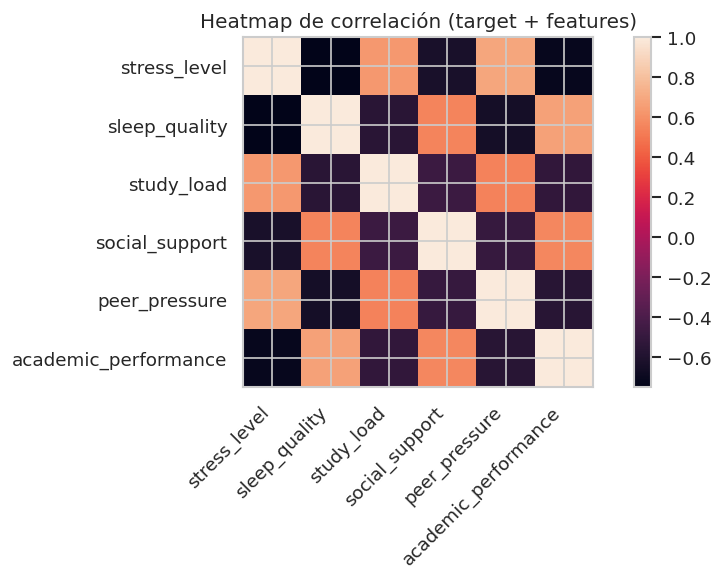

In [15]:
# Matriz de correlación para target + features
num_df = dplot.dropna()
if num_df.shape[1] >= 3 and len(num_df) > 0:
    corr = num_df.corr(numeric_only=True).round(3)
    print("Matriz de correlación (numérica):")
    display(corr)

    plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.title("Heatmap de correlación (target + features)")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes columnas numéricas completas para correlación.")


Interpretación de gráficos y hallazgos clave

Luego de cada figura, sintetizo el patrón principal (tendencia, umbrales, outliers, separación por clases). Destaco implicaciones prácticas: por ejemplo, si baja sleep_quality coincide con alto estrés, defino un umbral operativo que dispare descansos, bloques más cortos o intervención del tutor IA.

In [16]:
group_stats = (
    dplot.groupby(target_col)[features]
         .agg(['mean','std','median','count'])
         .round(3)
)
display(group_stats)
print("Orden sugerido de fuerza (ojo: signo indica dirección):")
speeds = dplot[[target_col]+features].corr(numeric_only=True)[target_col].sort_values(ascending=False)
display(speeds.to_frame('corr_pearson').round(3))


sleep_quality                     study_load                     social_support                      \
                      mean    std median count       mean    std median count           mean    std median count   
stress_level                                                                                                       
0                   4.1260 1.1630 4.0000   373     1.6540 0.9730 2.0000   373         2.5420 0.9540 3.0000   373   
1                   2.5310 0.8550 2.0000   358     2.5340 0.8520 2.0000   358         2.1790 0.9360 2.0000   358   
2                   1.3040 1.0220 1.0000   369     3.6860 1.1900 4.0000   369         0.9270 0.2610 1.0000   369   

             peer_pressure                     academic_performance                      
                      mean    std median count                 mean    std median count  
stress_level                                                                             
0                   1.6760 0.9390 2.0000   373               4.1420 1.1420 4.0000   373  
1                   2.4580 0.8210 2.0000   358               2.4920 0.8090 2.0000   358  
2                   4.0730 1.2300 4.0000   369               1.6610 0.8980 2.0000   369

Orden sugerido de fuerza (ojo: signo indica dirección):


,corr_pearson
stress_level,1.0000
peer_pressure,0.6910
study_load,0.6340
social_support,-0.6320
academic_performance,-0.7210
sleep_quality,-0.7490


In [17]:
# Correlación
def spearman(x, y):
    xr = x.rank(method='average')
    yr = y.rank(method='average')
    return xr.corr(yr)

results = []
for f in features:
    r = spearman(dplot[f], dplot[target_col])
    results.append((f, round(r,3)))
spearman_df = pd.DataFrame(results, columns=['feature','spearman_r']).sort_values('spearman_r', ascending=False)
display(spearman_df)


,feature,spearman_r
3,peer_pressure,0.6940
1,study_load,0.6660
2,social_support,-0.6440
4,academic_performance,-0.7280
0,sleep_quality,-0.7610


In [18]:
# Auditoría de colinealidad entre features
corrF = dplot[features].corr(numeric_only=True).round(3)
print("Correlación entre features:")
display(corrF)

high_pairs = []
for i, c1 in enumerate(features):
    for c2 in features[i+1:]:
        r = corrF.loc[c1, c2]
        if abs(r) >= 0.70:
            high_pairs.append((c1, c2, r))

flag_df = pd.DataFrame(high_pairs, columns=["feature_1","feature_2","corr_pearson_r"]).sort_values("corr_pearson_r", ascending=False)
print("\nPares con |r| ≥ 0.70 (posible redundancia):")
display(flag_df if not flag_df.empty else pd.DataFrame({"msg":["No se detectó alta colinealidad."]}))


Correlación entre features:


,sleep_quality,study_load,social_support,peer_pressure,academic_performance
sleep_quality,1.0000,-0.5520,0.5550,-0.6490,0.6710
study_load,-0.5520,1.0000,-0.4730,0.5440,-0.5200
social_support,0.5550,-0.4730,1.0000,-0.4900,0.5680
peer_pressure,-0.6490,0.5440,-0.4900,1.0000,-0.5630
academic_performance,0.6710,-0.5200,0.5680,-0.5630,1.0000



Pares con |r| ≥ 0.70 (posible redundancia):


,msg
0,No se detectó alta colinealidad.


In [19]:
# Selección final de features + resumen

def spearman(x, y):
    xr = x.rank(method='average'); yr = y.rank(method='average')
    return xr.corr(yr)

# Ranking por Spearman
results = [(f, round(spearman(dplot[f], dplot[target_col]),3)) for f in features]
spearman_df = pd.DataFrame(results, columns=['feature','spearman_r']).sort_values('spearman_r', ascending=False)
print("Ranking por Spearman:")
display(spearman_df)

# Selección final (como no hay colinealidad alta, mantenemos las 5)
final_features = features.copy()
print("Features finales seleccionadas:", final_features)

# Texto resumen
lines = []
lines.append(f"Target: {target_col} (nivel de estrés) con distribución equilibrada por clases.")
lines.append("Selección final de señales (no redundantes): " + ", ".join(final_features) + ".")
for f in final_features:
    if f == "sleep_quality":
        lines.append("- sleep_quality: relación inversa fuerte con el estrés (Spearman ≈ negativo alto).")
    elif f == "study_load":
        lines.append("- study_load: relación directa; mayor carga de estudio → mayor estrés.")
    elif f == "social_support":
        lines.append("- social_support: relación inversa; mayor apoyo → menor estrés.")
    elif f == "peer_pressure":
        lines.append("- peer_pressure: relación directa; más presión de pares → mayor estrés.")
    elif f == "academic_performance":
        lines.append("- academic_performance: relación inversa; peor desempeño → mayor estrés.")
    else:
        lines.append(f"- {f}: señal relevante asociada al estrés.")

lines.append("Evidencia EDA: boxplots confirman tendencias por nivel; scatter sugiere interacción (alta carga + bajo apoyo = mayor estrés).")
summary_text = "\n".join(lines)

print("\n=== RESUMEN EDA (para informe) ===")
print(summary_text)



Ranking por Spearman:


,feature,spearman_r
3,peer_pressure,0.6940
1,study_load,0.6660
2,social_support,-0.6440
4,academic_performance,-0.7280
0,sleep_quality,-0.7610


Features finales seleccionadas: ['sleep_quality', 'study_load', 'social_support', 'peer_pressure', 'academic_performance']

=== RESUMEN EDA (para informe) ===
Target: stress_level (nivel de estrés) con distribución equilibrada por clases.
Selección final de señales (no redundantes): sleep_quality, study_load, social_support, peer_pressure, academic_performance.
- sleep_quality: relación inversa fuerte con el estrés (Spearman ≈ negativo alto).
- study_load: relación directa; mayor carga de estudio → mayor estrés.
- social_support: relación inversa; mayor apoyo → menor estrés.
- peer_pressure: relación directa; más presión de pares → mayor estrés.
- academic_performance: relación inversa; peor desempeño → mayor estrés.
Evidencia EDA: boxplots confirman tendencias por nivel; scatter sugiere interacción (alta carga + bajo apoyo = mayor estrés).


# **Cómo conviertiría los hallazgos del EDA en acciones de la app**

A partir de que stress_level está balanceado y muestra relaciones robustas con mis señales (sleep_quality 🔼, study_load 🔼, peer_pressure 🔼, social_support 🔽, academic_performance 🔽), esto se veria así:

Reglas de activación:

Riesgo alto (alta prioridad):

sleep_quality ≤ 2 y study_load ≥ 3, o

peer_pressure ≥ 4, o academic_performance ≤ 2 y social_support ≤ 1.

Riesgo medio (vigilancia + apoyo puntual):

sleep_quality = 2–3 o study_load = 3 o social_support = 1–2.

Riesgo bajo:

sleep_quality ≥ 4 y study_load ≤ 2 y social_support ≥ 2.

Acciones adaptativas por nivel:

Alto estrés: reducir carga (bloques de 20–25 min), incluir pausas guiadas y microtutoría; priorizar ejercicios cortos y objetivos alcanzables.

Estrés medio: mantener ritmo con microexplicaciones, tarjetas de refuerzo y recordatorios suaves de higiene del sueño.

Estrés bajo: re-escalar gradualmente dificultad y duración de bloques; feedback positivo para consolidar hábitos.

Interacción clave detectada:
alto study_load + bajo social_support eleva el estrés.

→ Si study_load ≥ 3 y social_support ≤ 1, agregaría: checklist de planificación corta + sugerencia de “AI buddy”/foro/estudio acompañado dentro de la app.